In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import random
import math
import pims
import cv2
from scipy import interpolate
from scipy.signal import savgol_filter
import skimage.filters as sk_fil
import imutils
#from skimage.transform import rotate
from skimage.morphology import skeletonize
import sys

#### For use on your setup, change following path name to appropriate choice for your environment
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/')

#### For use on your setup, change folder name (myAnalyses) to appropriate choice for your environment
import myAnalyses.lowmag_analysis_OSS as dio
import myAnalyses.trace_boundary_fromMarco as mc

In [ ]:
#DEFINE FILE PATHS

#### For use on your setup, change following path name to appropriate choice for your environment
path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/buckling_raw_outsideClean/'
path_to_image_stack = path + r'*.tif'

#### Following example movie is provided - see Github repository. More movies available upon request
base = 'Results/buckling_agar_x4_10sec'

#other file names
saveFile_image1 = base+'_track.png'
saveFile_image2 = base+'_filamentFitting.png'
saveFile_image3 = base+'_trackedEnds.png'
saveMyData= base+r'_segmented_data.csv'


###########
#DEFINE PARAMETERS FOR THE ANALYSIS
###########

### PLOTTING 
verbose = True  #keep it on for testing and debugging
frameid=1       #sample frame to plot

### ACQUISITION PARAMETERS - FIXED BY THE MICROSCOPY ###
#um_per_px = 1/1.198    #optoscope 10x obj.    
um_per_px = 1.61        #olympus x4 obj.
#um_per_px = 0.8614        #optoscope x4 obj. blackfly
#um_per_px = 0.386        #optoscope x10 obj. cellcam
delta_t = 10 # seconds 

#### FILAMENT DETECTION PARAMAETERS - TO BE OPTIMISED FOR EACH MOVIE ###
#threshold for creating binary image, which the contour algorithm will use
#NOTE: the threshold coefficient should be experimented with here to get good contour detection
#change this parameter and explore effects in section 2 - do so, for a bunch of frames!
#coeffForThresh = 0.98 #decide a good coefficient. Values that usually work are 0.97, 1, or 1.1
coeffForThresh = 1
tolerance = 0.1 #tolerance on length detection

#spline parameters. 
#sparsity = 8   #determines how many of the original contour points is used for contour spline (every 20th). It is adjusted to ensure spline algorithm will work
sparsity = 100  #sparsity for buckling only
k_order_spline_filament = 3 # spline order
k_order_spline_track = 3 # spline order

###########
#LOAD TIMELAPSE, CHECK TYPE, NORMALISE INTENSITY
###########

#open image stack
frames = pims.open(path_to_image_stack)

#convert image datatype, first to float to normalise and then to uint8
#first get max pixel value
k=0
maxPixel=0
for frame in frames:
    intPixel = max(frame.flat)
    if intPixel>maxPixel:
        maxPixel=intPixel
        frameID = k
    k=k+1

#maxPixelValue = np.iinfo(frames[120].dtype).max             #get max allowed pixel value
frames1 = pims.pipeline(lambda x: x.astype(np.float32))(frames) #convert to float32 first
frames2 = pims.pipeline(lambda x: x*(255/maxPixel))(frames1) #normalize to 0-255 range
frames3 = pims.pipeline(lambda x: x.astype(np.uint8))(frames2)  #convert to uint8 
frames = frames3

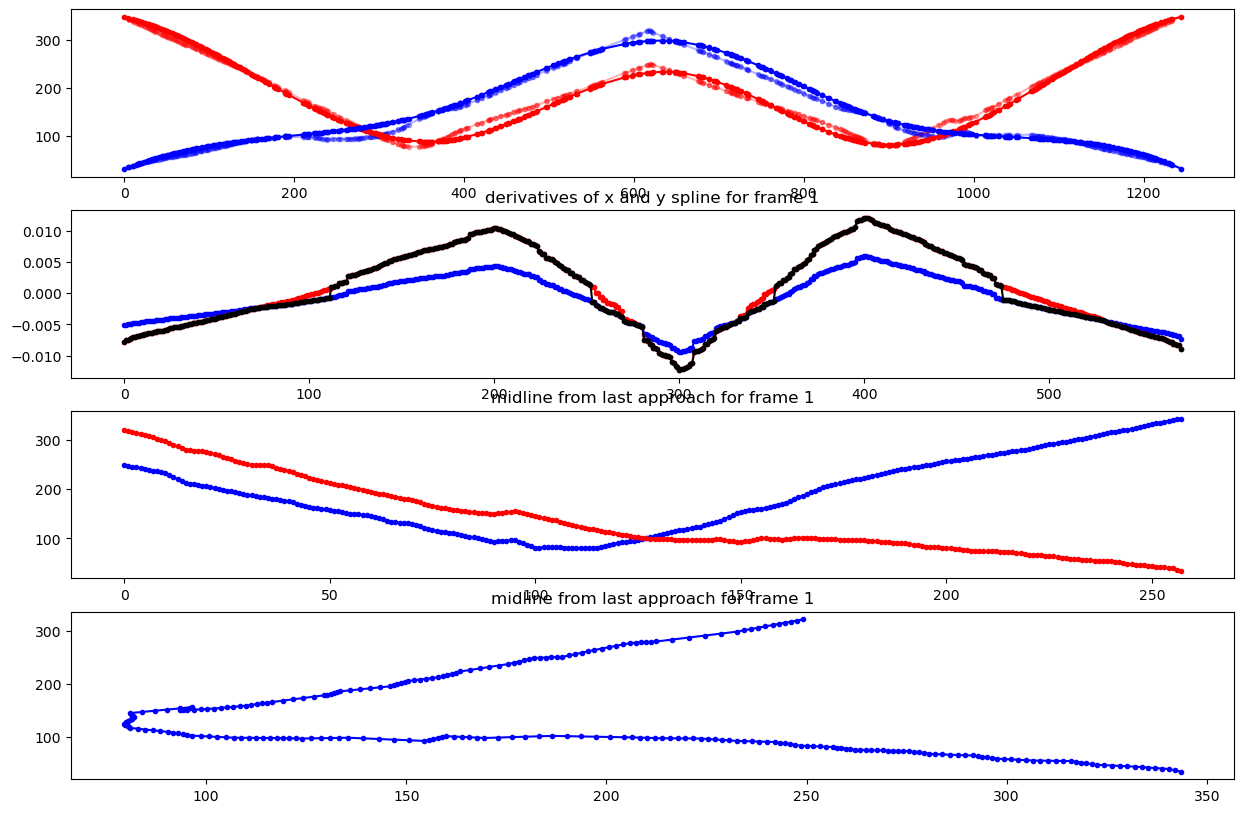

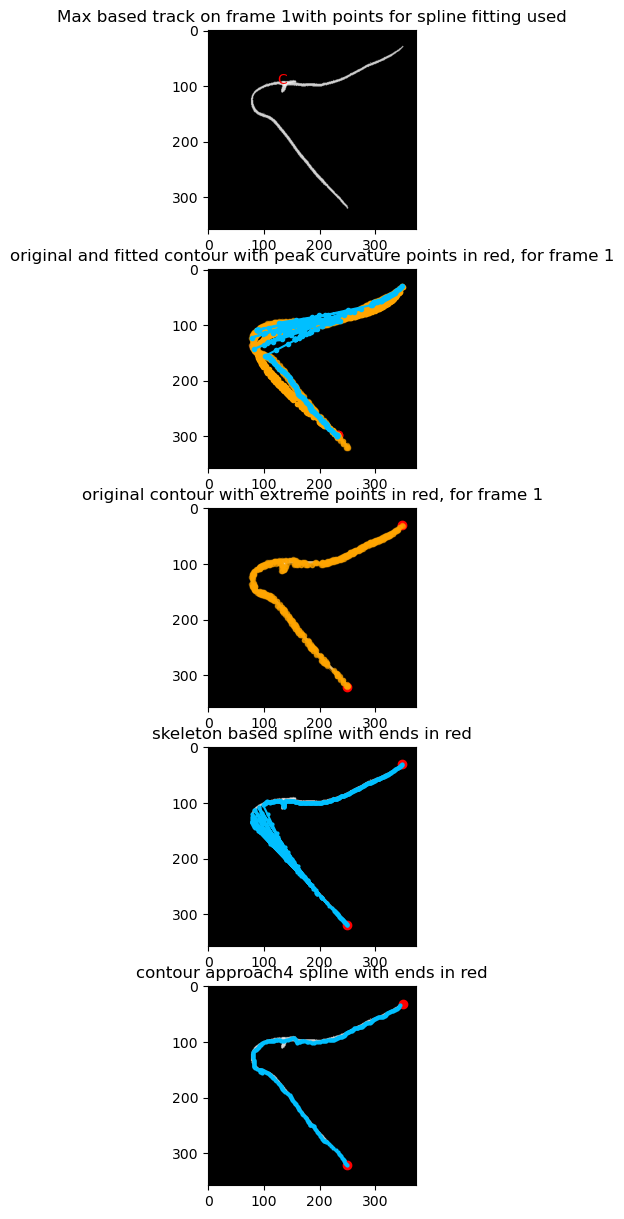

In [9]:

###########
#USE MAX PROJECTION JUST TO DECIDE EXTREME POINTS OF THE MOVEMENT FOR DISTANCE CALCULATIONS
###########

#the following is a max-projection of the timelapse, based on this: 
#https://stackoverflow.com/questions/48178916/maximum-intensity-projection-from-image-stack/52085463
IM_MAX= np.max(frames, axis=0)
thresh = sk_fil.threshold_yen(IM_MAX) 
ret,binary = cv2.threshold(IM_MAX,thresh,1,cv2.THRESH_BINARY)
IM_MAX2 = cv2.multiply(IM_MAX,binary)       #thresholded image


#find contours in the frame, to get the filament
contours = cv2.findContours(IM_MAX2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)    #note that this finds all the contours
cnts = imutils.grab_contours(contours)                                                      #get all contours that are found
cnt = max(cnts, key=cv2.contourArea)                                                        #pick the countour with max area - most likely to be our guy
x1 = cnt[:,0,0]                                                                             #x and y coordinates of the contour
y1 = cnt[:,0,1]


#SKELETON APPROACH
#get truth table for image, in terms of points within the countour vs outside
binaryImageInContour = np.empty(shape=[IM_MAX2.shape[0],IM_MAX2.shape[1]],dtype=bool)
binaryImageInContour[:,:] = 0
for i in range(0,IM_MAX2.shape[0],1): #y axis length
    for j in range(0,IM_MAX2.shape[1],1): #x axis length
        result = cv2.pointPolygonTest(cnt, (j,i), False)
        if (result==1): binaryImageInContour[i,j] = 1       #image with only pixels within or on contour
        else: binaryImageInContour[i,j] = 0
binaryImageInContour[y1,x1] = 1 
#skeleton_lee = skeletonize(binaryImageInContour, method='lee')
skeleton = skeletonize(binaryImageInContour)
#skeleton_line = np.where(skeleton_lee[:,:]==1)
skeleton_line = np.where(skeleton[:,:]==1)
skeleton_line_x1 = skeleton_line[1]
skeleton_line_y1 = skeleton_line[0]
skeleton_line_x, skeleton_line_y = dio.findExtremes_and_orderSkeleton(skeleton_line_x1, skeleton_line_y1)

#use skeloton as midline but just spline it
t_pts_mid = np.arange(0, len(skeleton_line_x),1) #indices for each point
t_sparse = np.arange(0, len(skeleton_line_x),5) #indices for every 5th point
if t_sparse[-1] != len(skeleton_line_x)-1: t_sparse = np.append(t_sparse,len(skeleton_line_x)-1)
midspline_x = interpolate.splrep(t_sparse,skeleton_line_x[t_sparse],s=0, k=1)
midspline_y = interpolate.splrep(t_sparse,skeleton_line_y[t_sparse],s=0, k=1)
mid_x_smooth_SKL = interpolate.splev(t_pts_mid, midspline_x)
mid_y_smooth_SKL = interpolate.splev(t_pts_mid, midspline_y)

#using the midline from skeleton, get length of filament and end points of it
midlinePoints_SKL = np.vstack((mid_x_smooth_SKL,mid_y_smooth_SKL)).T
filLength_inPx_SKL = dio.get_filamentLength_OSS(midlinePoints_SKL)
filLength_SKL = filLength_inPx_SKL*um_per_px

#CONTOUR APPROACH
#get the corners of the contour
extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0]) #smallest x-coordinate
extRight = tuple(cnt[cnt[:, :, 0].argmax()][0]) #largest x-coordinate
extTop = tuple(cnt[cnt[:, :, 1].argmin()][0]) #smallest y-coordinate
extBot = tuple(cnt[cnt[:, :, 1].argmax()][0]) ##largest y-coordinate
indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner = dio. get_indicesForCorners_OSS(cnt, extRight, extLeft, extTop, extBot)

#get the mid point of countour
xCentre, yCentre, xCentre2, yCentre2 = dio.getMidPointOfContour_OSS(x1,y1)

#get the indices to extreme end points of countour
end1_Border, end2_Border = dio.getExtremePoints_contour(x1,y1)
end1_Border_cum, end2_Border_cum = dio.getExtremePoints_fromCorners_contour(x1,y1,indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner)

#generate arrays corresponding to all and some of the contour points
t_pts = np.arange(0, len(x1),1) #indices for each point
happy = False
while (happy==False): 
    t_sparse = np.arange(0, len(x1),sparsity) #indices for every such and such point
    if t_sparse[-1] != len(x1)-1: t_sparse = np.append(t_sparse,len(x1)-1)
    if len(t_sparse)>k_order_spline_track: happy = True
    else: sparsity = sparsity-1

#generate cumulative distance array for the points, starting from 1st point in the contour
s = np.arange(0, len(x1),1)
cumdist=0
for i in range(1,len(x1),1):
    dist=np.sqrt((x1[i]-x1[i-1])**2+(y1[i]-y1[i-1])**2)
    cumdist = dist+cumdist
    s[i] = cumdist

#identify any duplicate points in s and add small amounts to them
s_unique=np.copy(s)
uniquePs, uniquePs_indices = np.unique(s, axis=0,return_index=True)
dupPointIndices = np.setdiff1d(np.arange(0,len(x1),1),uniquePs_indices)
if len(dupPointIndices)>0:
    for i in range(0,len(dupPointIndices)): s_unique[dupPointIndices[i]] += random.uniform(0, 0.01)
    s = np.copy(s_unique)

#using the distance order, spline fit x and y coordinates of the contour (using every 10th data point)
spline_x_S = interpolate.splrep(s[t_sparse],x1[t_sparse],s=0, k=k_order_spline_track)
spline_y_S = interpolate.splrep(s[t_sparse],y1[t_sparse],s=0, k=k_order_spline_track)

#use fitted spline to get smooth curves for x and y coordinates (at every point) and 2nd derivatives of those curves
x_S_smooth = interpolate.splev(s[t_pts], spline_x_S)
y_S_smooth = interpolate.splev(s[t_pts], spline_y_S)
x_spl_S_2d = interpolate.splev(s[t_pts], spline_x_S, der=2)
y_spl_S_2d = interpolate.splev(s[t_pts], spline_y_S, der=2)

#get peaks using the 2nd derivatives
dum_S = np.copy(y_spl_S_2d)
entriesToChange = np.where(np.abs(x_spl_S_2d)>np.abs(y_spl_S_2d))
dum_S[entriesToChange] = x_spl_S_2d[entriesToChange]
peak1_S_a, peak2_S_a = np.where(dum_S==np.max(dum_S)), np.where(dum_S==np.min(dum_S))
peak1_S = peak1_S_a[0][0]
peak2_S = peak2_S_a[0][0]

#using the peak points, trace the original contour to get a midline and its smooth fit
mid_x_smooth, mid_y_smooth = dio.getMidLineOfCountour(x1,y1,peak1_S,peak2_S)

#using the end points, trace the original contour to get a midline and its smooth fit
mid_x_smooth2, mid_y_smooth2, mid_x_2, mid_y_2 = dio.getMidLineOfCountour_better(x1,y1,end1_Border_cum, end2_Border_cum )


#plot things to see
if (verbose == True):
    fig, ax = plt.subplots(4,1, figsize=(15,10))
    #plot original contour and its spline againts cumulative distance of points (from 1st point) 
    ax[0].plot(s,x1,'o-',markersize=3,color='r',alpha=0.3)  
    ax[0].plot(s,y1,'o-',markersize=3,color='b',alpha=0.3)  
    ax[0].plot(s,x_S_smooth,'o-',markersize=3,color='r')  
    ax[0].plot(s,y_S_smooth,'o-',markersize=3,color='b')
    #plot spline derivaties and combined derivative from x and y curves 
    ax[1].plot(y_spl_S_2d,'o-',markersize=3,color='b') 
    ax[1].plot(x_spl_S_2d,'o-',markersize=3,color='r') 
    ax[1].plot(dum_S,'o-',markersize=3,color='k')
    ax[1].set_title(str('derivatives of x and y spline for frame '+str(frameid))) 
    #plot midline x and y
    ax[2].plot(mid_x_smooth2,'o-',markersize=3,color='b') 
    ax[2].plot(mid_y_smooth2,'o-',markersize=3,color='r') 
    ax[2].set_title(str('midline from last approach for frame '+str(frameid))) 
    #plot midline x and y
    ax[3].plot(mid_x_smooth2,mid_y_smooth2,'o-',markersize=3,color='b') 
    ax[3].set_title(str('midline from last approach for frame '+str(frameid))) 

    fig, ax = plt.subplots(5,1, figsize=(15,15))
    #plot MAX PROJECTION and midpoint of track
    ax[0].imshow(IM_MAX2,cmap="gray")
    ax[0].annotate('C',xy=(xCentre,yCentre),color='red')
    ax[0].set_title(str('Max based track on frame '+str(frameid) + 'with points for spline fitting used'))
    #show original and spline fitted curves on the image, with peaks shown in red
    ax[1].imshow(IM_MAX2,cmap="gray")
    ax[1].plot(x1,y1,'o-',markersize=3,color='orange',alpha=0.5)
    ax[1].plot(x_S_smooth,y_S_smooth,'o-',markersize=3,color='orange')
    ax[1].scatter(x1[peak1_S],y1[peak1_S],color='r')
    ax[1].scatter(x1[peak2_S],y1[peak2_S],color='r') 
    ax[1].scatter(x_S_smooth[peak1_S],y_S_smooth[peak1_S],color='b')
    ax[1].scatter(x_S_smooth[peak2_S],y_S_smooth[peak2_S],color='r')   
    ax[1].plot(mid_x_smooth,mid_y_smooth,'o-',markersize=3,color='deepskyblue')
    ax[1].set_title(str('original and fitted contour with peak curvature points in red, for frame '+str(frameid))) 
    #show contour, with extreme ends in red
    ax[2].imshow(IM_MAX2,cmap="gray")
    ax[2].plot(x1,y1,'o-',markersize=3,color='orange',alpha=0.5)
    ax[2].scatter(x1[end1_Border],y1[end1_Border],color='r')
    ax[2].scatter(x1[end2_Border],y1[end2_Border],color='r')   
    ax[2].set_title(str('original contour with extreme points in red, for frame '+str(frameid))) 

    ax[3].imshow(IM_MAX2,cmap="gray")
    ax[3].plot(mid_x_smooth_SKL, mid_y_smooth_SKL,'o-',markersize=2,color='deepskyblue')  #skeleton spline
    ax[3].scatter(mid_x_smooth_SKL[0],mid_y_smooth_SKL[0],color='r')
    ax[3].scatter(mid_x_smooth_SKL[-1],mid_y_smooth_SKL[-1],color='r') 
    ax[3].set_title(str('skeleton based spline with ends in red'))

    ax[4].imshow(IM_MAX2,cmap="gray")
    ax[4].plot(mid_x_smooth2, mid_y_smooth2,'o-',markersize=2,color='deepskyblue')  #skeleton spline
    ax[4].scatter(x1[end1_Border_cum],y1[end1_Border_cum],color='r')
    ax[4].scatter(x1[end2_Border_cum],y1[end2_Border_cum],color='r') 
    ax[4].set_title(str('contour approach4 spline with ends in red'))

    fig.savefig(saveFile_image1)
    plt.show()
    plt.close(fig)
    

In [10]:
#take input from user to decide which approach and length_acceptable  
input_var = int(input("Enter 1 for skeleton, 0 or 2 for contour-based options: "))
if (input_var == 0):
    #using the midline, get length of track 
    endToEndLength_Track = np. sqrt((mid_x_smooth[0]-mid_x_smooth[-1])**2 + (mid_y_smooth[0]-mid_y_smooth[-1])**2)
    midlinePoints = np.vstack((mid_x_smooth,mid_y_smooth)).T

    #pick track end points using extreme points of the original contour
    trackEndPointA = np.array([x1[end1_Border],y1[end1_Border]])  
    trackEndPointB = np.array([x1[end2_Border],y1[end2_Border]])  

if (input_var == 1):
    #using the midline, get length of track 
    endToEndLength_Track = np. sqrt((mid_x_smooth_SKL[0]-mid_x_smooth_SKL[-1])**2 + (mid_y_smooth_SKL[0]-mid_y_smooth_SKL[-1])**2)
    midlinePoints = np.vstack((mid_x_smooth_SKL,mid_y_smooth_SKL)).T

    #pick track end points using extreme points of the original contour
    trackEndPointA = np.array([mid_x_smooth_SKL[0],mid_y_smooth_SKL[0]])  
    trackEndPointB = np.array([mid_x_smooth_SKL[-1],mid_y_smooth_SKL[-1]])  

if (input_var == 2):
    #using the midline, get length of track 
    endToEndLength_Track = np. sqrt((mid_x_smooth2[0]-mid_x_smooth2[-1])**2 + (mid_y_smooth2[0]-mid_y_smooth2[-1])**2)
    midlinePoints = np.vstack((mid_x_smooth2,mid_y_smooth2)).T

    #pick track end points using extreme points of the original contour
    trackEndPointA = np.array([x1[end1_Border_cum],y1[end1_Border_cum]])  
    trackEndPointB = np.array([x1[end2_Border_cum],y1[end2_Border_cum]]) 

trackLength_inPx = dio.get_filamentLength_OSS(midlinePoints)
trackLength = trackLength_inPx*um_per_px
trackLength

946.5400863650443

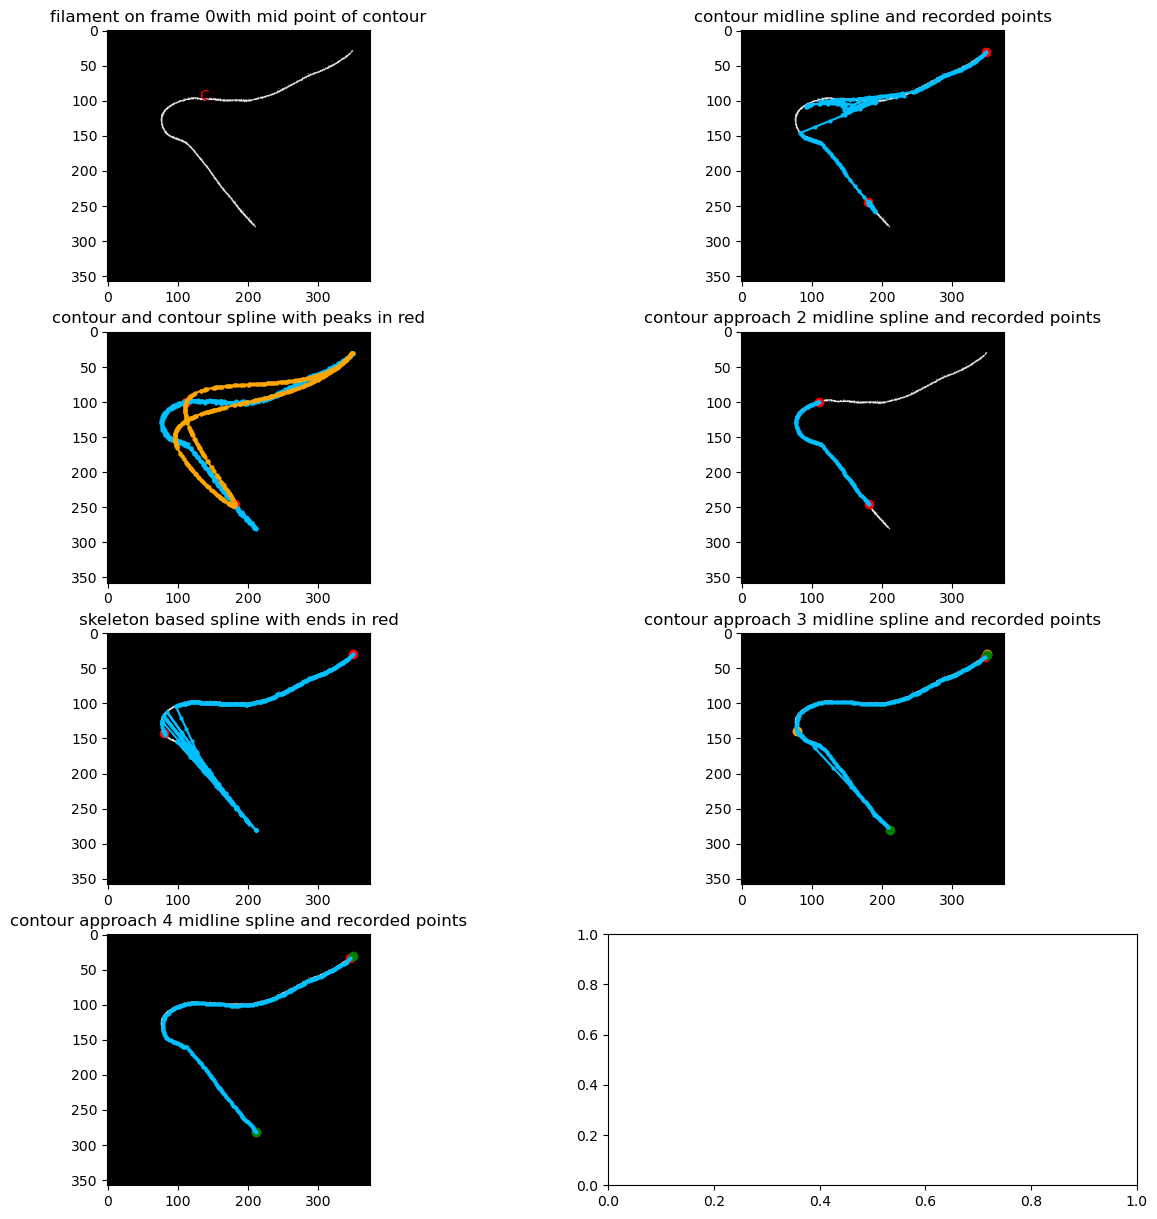

(4302.9660131216815, 818.5358653817283, 541, 272, 184, 542)

In [11]:

###########
#TEST THAT SPLINE FITTING WORKS USING 0'th FRAME AND STORE VALUES
###########

#arrays to store the frame, x-y of one end, x-y of other end, x-y of centre, and filament length
filamentData = np.empty(shape=[0, 8])

frame=frames[0]

#  yen threshold the image
thresh = sk_fil.threshold_yen(frame)  #returns a sensible threshold based on intenstity distribution
ret,binary = cv2.threshold(frame,thresh,1,cv2.THRESH_BINARY)
frame_thresholded = cv2.multiply(frame,binary)       #thresholded image

#find contours in the frame, to get the filament
contours = cv2.findContours(frame_thresholded,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)    #note that this finds all the contours
cnts = imutils.grab_contours(contours)                                                      #get all contours that are found
cnt = max(cnts, key=cv2.contourArea)                                                        #pick the countour with max area - most likely to be our guy
x1 = cnt[:,0,0]                                                                             #x and y coordinates of the contour
y1 = cnt[:,0,1]

#get the corners of the contour
extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0]) #smallest x-coordinate
extRight = tuple(cnt[cnt[:, :, 0].argmax()][0]) #largest x-coordinate
extTop = tuple(cnt[cnt[:, :, 1].argmin()][0]) #smallest y-coordinate
extBot = tuple(cnt[cnt[:, :, 1].argmax()][0]) ##largest y-coordinate
indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner = dio. get_indicesForCorners_OSS(cnt, extRight, extLeft, extTop, extBot)

#get the mid point of countour
xCentre, yCentre, xCentre2, yCentre2 = dio.getMidPointOfContour_OSS(x1,y1)

#get the indices to extreme end points of countour
end1_Border, end2_Border = dio.getExtremePoints_contour(x1,y1)

#get the indices to extreme end points of countour using corner points
end1_Border_cum, end2_Border_cum = dio.getExtremePoints_fromCorners_contour(x1,y1,indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner)

#skeleton approach
#get truth table for image, in terms of points within the countour vs outside
binaryImageInContour = np.empty(shape=[frame.shape[0],frame.shape[1]],dtype=bool)
binaryImageInContour[:,:] = 0
for i in range(0,frame.shape[0],1): #y axis length
    for j in range(0,frame.shape[1],1): #x axis length
        result = cv2.pointPolygonTest(cnt, (j,i), False)
        if (result==1): binaryImageInContour[i,j] = 1       #image with only pixels within or on contour
        else: binaryImageInContour[i,j] = 0
binaryImageInContour[y1,x1] = 1 
#skeleton_lee = skeletonize(binaryImageInContour, method='lee')
skeleton = skeletonize(binaryImageInContour)
#skeleton_line = np.where(skeleton_lee[:,:]==1)
skeleton_line = np.where(skeleton[:,:]==1)
skeleton_line_x1 = skeleton_line[1]
skeleton_line_y1 = skeleton_line[0]
skeleton_line_x, skeleton_line_y = dio.findExtremes_and_orderSkeleton(skeleton_line_x1, skeleton_line_y1)

#generate arrays corresponding to all and some of the contour points
t_pts = np.arange(0, len(x1),1) #indices for each point
happy = False
while (happy==False): 
    t_sparse = np.arange(0, len(x1),sparsity) #indices for every such and such point
    if t_sparse[-1] != len(x1)-1: t_sparse = np.append(t_sparse,len(x1)-1)
    if len(t_sparse)>k_order_spline_filament: happy = True
    else: sparsity = sparsity-1

#generate cumulative distance array for the points, starting from 1st point in the contour
s = np.arange(0, len(x1),1)
cumdist=0
for i in range(1,len(x1),1):
    dist=np.sqrt((x1[i]-x1[i-1])**2+(y1[i]-y1[i-1])**2)
    cumdist = dist+cumdist
    s[i] = cumdist

#identify any duplicate points in s and add small amounts to them
s_unique=np.copy(s)
uniquePs, uniquePs_indices = np.unique(s, axis=0,return_index=True)
dupPointIndices = np.setdiff1d(np.arange(0,len(x1),1),uniquePs_indices)
if len(dupPointIndices)>0:
    for i in range(0,len(dupPointIndices)): s_unique[dupPointIndices[i]] += random.uniform(0, 0.01)
    s = np.copy(s_unique)

#using the distance order, spline fit x and y coordinates of the contour (using every 10th data point)
spline_x_S = interpolate.splrep(s[t_sparse],x1[t_sparse],s=0, k=k_order_spline_filament)
spline_y_S = interpolate.splrep(s[t_sparse],y1[t_sparse],s=0, k=k_order_spline_filament)

#use fitted spline to get smooth curves for x and y coordinates (at every point) and 2nd derivatives of those curves
x_S_smooth = interpolate.splev(s[t_pts], spline_x_S)
y_S_smooth = interpolate.splev(s[t_pts], spline_y_S)
x_spl_S_2d = interpolate.splev(s[t_pts], spline_x_S, der=2)
y_spl_S_2d = interpolate.splev(s[t_pts], spline_y_S, der=2)

#get peaks using the 2nd derivatives
dum_S = np.copy(y_spl_S_2d)
entriesToChange = np.where(np.abs(x_spl_S_2d)>np.abs(y_spl_S_2d))
dum_S[entriesToChange] = x_spl_S_2d[entriesToChange]
peak1_S_a, peak2_S_a = np.where(dum_S==np.max(dum_S)), np.where(dum_S==np.min(dum_S))
peak1_S = peak1_S_a[0][0]
peak2_S = peak2_S_a[0][0]

#using the peak points, trace the original contour to get a midline and its smooth fit
mid_x_smooth, mid_y_smooth = dio.getMidLineOfCountour(x1,y1,peak1_S,peak2_S)

#get ordered contour and pick filament end locations from this ordered contour
border_pos = mc.trace_boundary(binaryImageInContour)
if (len(border_pos[:,1])>10):
    x_orderedContour = border_pos[:,1]
    y_orderedContour = border_pos[:,0]
    peak1_Border = 0
    peak2_Border = int(len(x_orderedContour)/2)
else:
    x_orderedContour = np.copy(x1)
    y_orderedContour = np.copy(y1)
    peak1_Border, peak2_Border = peak1_S, peak2_S

#using the ordered contour points, trace the original contour to get a midline and its smooth fit
#mid_x_smooth2, mid_y_smooth2 = dio.getMidLineOfCountour(x_orderedContour,y_orderedContour,peak1_Border,peak2_Border)
mid_x_smooth2, mid_y_smooth2,mid_x_2, mid_y_2 = dio.getMidLineOfCountour_better(x_orderedContour,y_orderedContour,peak1_Border,peak2_Border)

#using the extreme contour points, trace the original contour to get a midline and its smooth fit
#mid_x_smooth3, mid_y_smooth3 = dio.getMidLineOfCountour(x1,y1,end1_Border,end2_Border)
mid_x_smooth3, mid_y_smooth3,mid_x_3, mid_y_3 = dio.getMidLineOfCountour_better(x1,y1,end1_Border,end2_Border)

#using the end points, trace the original contour to get a midline and its smooth fit
mid_x_smooth4, mid_y_smooth4,mid_x_4, mid_y_4 = dio.getMidLineOfCountour_better(x1,y1,end1_Border_cum,end2_Border_cum)

#ALTERNATIVE: use skeloton as midline but just spline it
t_pts_mid = np.arange(0, len(skeleton_line_x),1) #indices for each point
t_sparse = np.arange(0, len(skeleton_line_x),5) #indices for every 5th point
if t_sparse[-1] != len(skeleton_line_x)-1: t_sparse = np.append(t_sparse,len(skeleton_line_x)-1)
midspline_x = interpolate.splrep(t_sparse,skeleton_line_x[t_sparse],s=0, k=1)
midspline_y = interpolate.splrep(t_sparse,skeleton_line_y[t_sparse],s=0, k=1)
mid_x_smooth_SKL = interpolate.splev(t_pts_mid, midspline_x)
mid_y_smooth_SKL = interpolate.splev(t_pts_mid, midspline_y)

#using the midline from contour, get length of filament and end points of it
midlinePoints = np.vstack((mid_x_smooth,mid_y_smooth)).T
filLength_inPx_contourBased = dio.get_filamentLength_OSS(midlinePoints)
filLength_contourBased = filLength_inPx_contourBased*um_per_px

#using the midline from ordered contour, get length of filament and end points of it
midlinePoints2 = np.vstack((mid_x_smooth2,mid_y_smooth2)).T
filLength_inPx_contourBased2 = dio.get_filamentLength_OSS(midlinePoints2)
filLength_contourBased2 = filLength_inPx_contourBased2*um_per_px

#using the midline from extreme ends of  contour, get length of filament and end points of it
midlinePoints3 = np.vstack((mid_x_smooth3,mid_y_smooth3)).T
filLength_inPx_contourBased3 = dio.get_filamentLength_OSS(midlinePoints3)
filLength_contourBased3 = filLength_inPx_contourBased3*um_per_px

#using the midline from ends of contour, get length of filament and end points of it
midlinePoints4 = np.vstack((mid_x_smooth4,mid_y_smooth4)).T
filLength_inPx_contourBased4 = dio.get_filamentLength_OSS(midlinePoints4)
filLength_contourBased4 = filLength_inPx_contourBased4*um_per_px

#using the midline from skeleton, get length of filament and end points of it
midlinePoints_SKL = np.vstack((mid_x_smooth_SKL,mid_y_smooth_SKL)).T
filLength_inPx_SKL = dio.get_filamentLength_OSS(midlinePoints_SKL)
filLength_SKL = filLength_inPx_SKL*um_per_px

if (verbose == True):
    fig, ax = plt.subplots(4,2, figsize=(15,15))
    ax[0,0].imshow(frame_thresholded,cmap="gray")
    ax[0,0].annotate('C',xy=(xCentre,yCentre),color='red')
    ax[0,0].set_title(str('filament on frame '+str(0) + 'with mid point of contour'))

    ax[1,0].imshow(frame_thresholded,cmap="gray")
    ax[1,0].plot(x1, y1,'o-',markersize=2,color='deepskyblue')  #full spline
    ax[1,0].plot(x_S_smooth, y_S_smooth,'o-',markersize=2,color='orange')  #full spline
    ax[1,0].scatter(x1[peak1_S],y1[peak1_S],color='r')
    ax[1,0].scatter(x1[peak2_S],y1[peak2_S],color='r') 
    ax[1,0].set_title(str('contour and contour spline with peaks in red'))

    ax[2,0].imshow(frame_thresholded,cmap="gray")
    ax[2,0].plot(mid_x_smooth_SKL, mid_y_smooth_SKL,'o-',markersize=2,color='deepskyblue')  #skeleton spline
    ax[2,0].scatter(mid_x_smooth_SKL[0],mid_y_smooth_SKL[0],color='r')
    ax[2,0].scatter(mid_x_smooth_SKL[-1],mid_y_smooth_SKL[-1],color='r') 
    ax[2,0].set_title(str('skeleton based spline with ends in red'))
    
    ax[0,1].imshow(frame_thresholded,cmap="gray")
    ax[0,1].plot(mid_x_smooth, mid_y_smooth,'o-',markersize=2,color='deepskyblue')  #full spline
    ax[0,1].scatter(mid_x_smooth[0],mid_y_smooth[0],color='r')
    ax[0,1].scatter(mid_x_smooth[-1],mid_y_smooth[-1],color='r') 
    ax[0,1].set_title(str('contour midline spline and recorded points')) 

    ax[1,1].imshow(frame_thresholded,cmap="gray")
    ax[1,1].plot(mid_x_smooth2, mid_y_smooth2,'o-',markersize=2,color='deepskyblue')  #full spline
    ax[1,1].scatter(mid_x_smooth2[0],mid_y_smooth2[0],color='r')
    ax[1,1].scatter(mid_x_smooth2[-1],mid_y_smooth2[-1],color='r') 
    ax[1,1].set_title(str('contour approach 2 midline spline and recorded points')) 

    ax[2,1].imshow(frame_thresholded,cmap="gray")
    ax[2,1].plot(mid_x_smooth3, mid_y_smooth3,'o-',markersize=2,color='deepskyblue')  #full spline
    ax[2,1].scatter(mid_x_smooth3[0],mid_y_smooth3[0],color='r')
    ax[2,1].scatter(mid_x_smooth3[-1],mid_y_smooth3[-1],color='r')
    ax[2,1].scatter(x1[end1_Border],y1[end1_Border],color='orange')
    ax[2,1].scatter(x1[end2_Border],y1[end2_Border],color='orange') 
    ax[2,1].scatter(x1[end1_Border_cum],y1[end1_Border_cum],color='green')
    ax[2,1].scatter(x1[end2_Border_cum],y1[end2_Border_cum],color='green') 
    ax[2,1].set_title(str('contour approach 3 midline spline and recorded points')) 

    ax[3,0].imshow(frame_thresholded,cmap="gray")
    ax[3,0].plot(mid_x_smooth4, mid_y_smooth4,'o-',markersize=2,color='deepskyblue')  #full spline
    ax[3,0].scatter(mid_x_smooth4[0],mid_y_smooth4[0],color='r')
    ax[3,0].scatter(mid_x_smooth4[-1],mid_y_smooth4[-1],color='r') 
    ax[3,0].scatter(x1[end1_Border_cum],y1[end1_Border_cum],color='green')
    ax[3,0].scatter(x1[end2_Border_cum],y1[end2_Border_cum],color='green') 
    ax[3,0].set_title(str('contour approach 4 midline spline and recorded points'))

    fig.savefig(saveFile_image2)
    plt.show()
    plt.close(fig)

filLength_SKL, filLength_contourBased4,end1_Border_cum,end2_Border_cum,end1_Border,end2_Border

In [12]:

#take input from user to decide which approach and length_acceptable  
input_var = int(input("Enter 1 for skeleton, 0 for contour-based, 2,3, 4 for contour-based approach2,3, 4 length to be used: "))
if (input_var == 0):
    filLength = filLength_contourBased
    filLength_inPx = filLength_inPx_contourBased
    endA_x = mid_x_smooth[0]
    endA_y = mid_y_smooth[0]
    endB_x = mid_x_smooth[-1]
    endB_y = mid_y_smooth[-1]
if (input_var == 1):
    approachUsed = 1
    filLength = filLength_SKL
    filLength_inPx = filLength_inPx_SKL
    endA_x = mid_x_smooth_SKL[0]
    endA_y = mid_y_smooth_SKL[0]
    endB_x = mid_x_smooth_SKL[-1]
    endB_y = mid_y_smooth_SKL[-1]
if (input_var == 2):
    approachUsed = 2
    filLength = filLength_contourBased2
    filLength_inPx = filLength_inPx_contourBased2
    endA_x = mid_x_smooth2[0]
    endA_y = mid_y_smooth2[0]
    endB_x = mid_x_smooth2[-1]
    endB_y = mid_y_smooth2[-1]
if (input_var == 3):
    approachUsed = 3
    filLength = filLength_contourBased3
    filLength_inPx = filLength_inPx_contourBased3
    endA_x = mid_x_smooth3[0]
    endA_y = mid_y_smooth3[0]
    endB_x = mid_x_smooth3[-1]
    endB_y = mid_y_smooth3[-1]
if (input_var == 4):
    approachUsed = 4
    filLength = filLength_contourBased4
    filLength_inPx = filLength_inPx_contourBased4
    endA_x = mid_x_smooth4[0]
    endA_y = mid_y_smooth4[0]
    endB_x = mid_x_smooth4[-1]
    endB_y = mid_y_smooth4[-1]
endA_x2, endA_y2 = endA_x, endA_y
endB_x2, endB_y2 = endB_x, endB_y
filLength_acceptable = filLength

#get average end points using identified end points and the contour
averagingDist = filLength_inPx*0.05
indicesforNeighborhood_A=np.where(np.sqrt((x1-endA_x)**2+(y1-endA_y)**2)<averagingDist)
if len(indicesforNeighborhood_A)>1:
    endA_x2 =np.mean(x1[indicesforNeighborhood_A])
    endA_y2 =np.mean(y1[indicesforNeighborhood_A])
indicesforNeighborhood_B=np.where(np.sqrt((x1-endB_x)**2+(y1-endB_y)**2)<averagingDist)
if len(indicesforNeighborhood_B)>1:
    endB_x2 =np.mean(x1[indicesforNeighborhood_B])
    endB_y2 =np.mean(y1[indicesforNeighborhood_B])

### RECORD FILAMENT LENGTH AND END POINTS ###
filamentData = np.append(filamentData,[[0,endA_x2,endA_y2,endB_x2,endB_y2,xCentre,yCentre,filLength]],axis=0)
filLength_acceptable

818.5358653817283

Frame: 1 	 using spline with filLength_um : 825.968720 4
Frame: 2 	 using spline with filLength_um : 821.690835 4
Frame: 3 	 using spline with filLength_um : 823.572304 4
Frame: 4 	 using spline with filLength_um : 822.511544 4
Frame: 5 	 using spline with filLength_um : 825.602044 4
Frame: 6 	 using spline with filLength_um : 826.400325 3
Frame: 7 	 using spline with filLength_um : 816.711276 3
Frame: 8 	 using spline with filLength_um : 819.145414 3
Frame: 9 	 using spline with filLength_um : 812.617643 3
Frame: 10 	 using spline with filLength_um : 823.117353 3
Frame: 11 	 using spline with filLength_um : 822.300972 3
Frame: 12 	 using spline with filLength_um : 821.552029 3
Frame: 13 	 using spline with filLength_um : 820.451605 3
Frame: 14 	 using spline with filLength_um : 821.654675 3
Frame: 15 	 using spline with filLength_um : 821.882972 4
Frame: 16 	 using spline with filLength_um : 816.009640 3
Frame: 17 	 using spline with filLength_um : 811.347199 3
Frame: 18 	 using splin

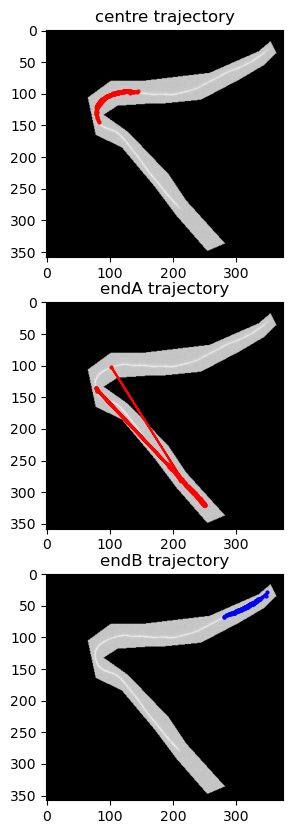

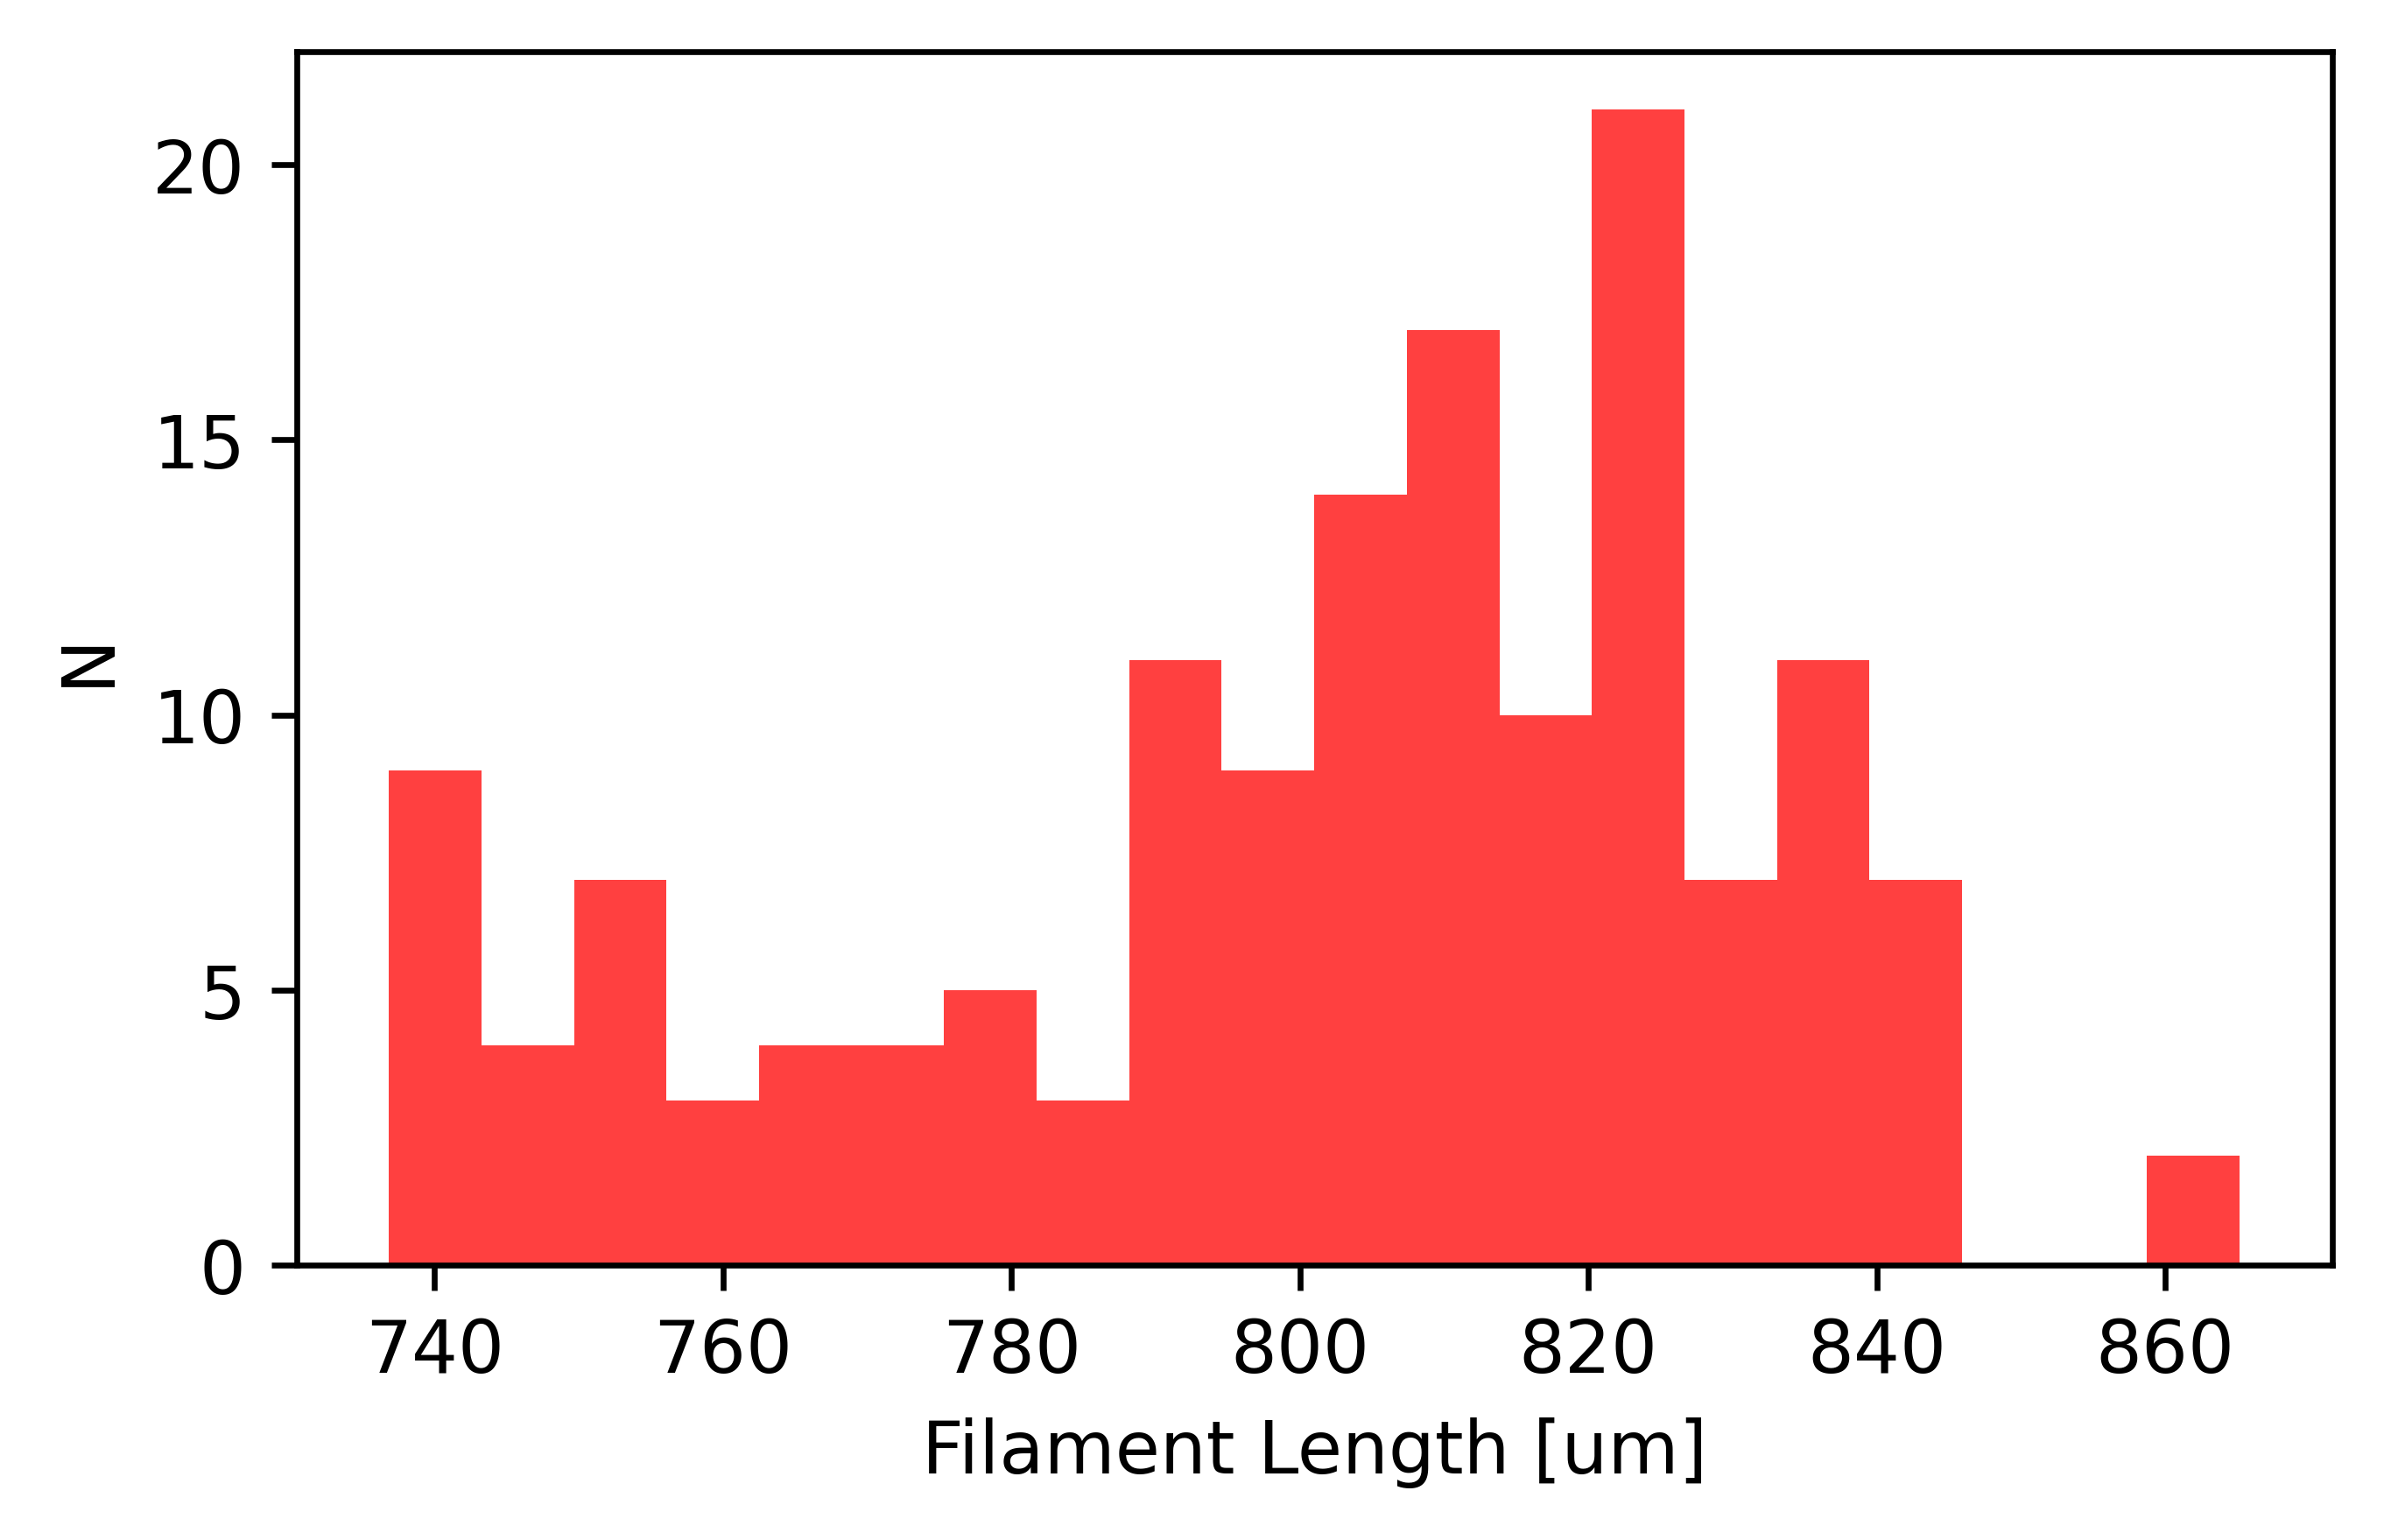

In [13]:

###########
#LOOP THROUGH FRAMES, FIT SPLINE TO FILAMENT, IDENTIFY END POINTS AND CALCULATE SPEED, ETC.
###########

lastGoodFrame = 0
#main loop through frames of the timalapse
for frameCounter in range(1, len(frames)):

    frame=frames[frameCounter]

    skipFrame = False
    # yen threshold the frame
    thresh = sk_fil.threshold_yen(frame)  #returns a sensible threshold based on intenstity distribution
    ret,binary = cv2.threshold(frame,thresh,1,cv2.THRESH_BINARY)
    frame_thresholded = cv2.multiply(frame,binary)       #thresholded image

    #find contours in the frame, to get the filament
    #NOTE: The function we use returns all contours, but we pick the one with largest area
    #as this is likely to be our filament - given we work with single filament movies
    contours = cv2.findContours(frame_thresholded,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)
    cnt = max(cnts, key=cv2.contourArea)
    x1 = cnt[:,0,0]                         #x and y coordinates of contour
    y1 = cnt[:,0,1]

    #get the corners of the contour
    extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0]) #smallest x-coordinate
    extRight = tuple(cnt[cnt[:, :, 0].argmax()][0]) #largest x-coordinate
    extTop = tuple(cnt[cnt[:, :, 1].argmin()][0]) #smallest y-coordinate
    extBot = tuple(cnt[cnt[:, :, 1].argmax()][0]) ##largest y-coordinate
    indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner = dio. get_indicesForCorners_OSS(cnt, extRight, extLeft, extTop, extBot)

    #get the mid point of countour
    xCentre, yCentre, xCentre2, yCentre2 = dio.getMidPointOfContour_OSS(x1,y1)

    #get the indices to extreme end points of countour
    end1_Border, end2_Border= dio.getExtremePoints_contour(x1,y1)

    #get the indices to extreme end points of countour using corner points
    end1_Border_cum, end2_Border_cum = dio.getExtremePoints_fromCorners_contour(x1,y1,indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner)

    #get truth table for image, in terms of points within the countour vs outside
    binaryImageInContour = np.empty(shape=[frame.shape[0],frame.shape[1]],dtype=bool)
    binaryImageInContour[:,:] = 0
    for i in range(0,frame.shape[0],1): #y axis length
        for j in range(0,frame.shape[1],1): #x axis length
            result = cv2.pointPolygonTest(cnt, (j,i), False)
            if (result==1): binaryImageInContour[i,j] = 1       #image with only pixels within contour
            else: binaryImageInContour[i,j] = 0
    binaryImageInContour[y1,x1] = 1 
    skeleton = skeletonize(binaryImageInContour)
    skeleton_line = np.where(skeleton[:,:]==1)
    skeleton_line_x1 = skeleton_line[1]
    skeleton_line_y1 = skeleton_line[0]
    skeleton_line_x, skeleton_line_y = dio.findExtremes_and_orderSkeleton(skeleton_line_x1, skeleton_line_y1)

    #generate arrays corresponding to all and some of the contour points
    t_pts = np.arange(0, len(x1),1) #indices for each point
    happy = False
    while (happy==False): 
        t_sparse = np.arange(0, len(x1),sparsity) #indices for every such and such point
        if t_sparse[-1] != len(x1)-1: t_sparse = np.append(t_sparse,len(x1)-1)
        if len(t_sparse)>k_order_spline_filament: happy = True
        else: sparsity = sparsity-1

    #generate cumulative distance array for the points, starting from 1st point in the contour
    s = np.arange(0, len(x1),1)
    cumdist=0
    for i in range(1,len(x1),1):
        dist=np.sqrt((x1[i]-x1[i-1])**2+(y1[i]-y1[i-1])**2)
        cumdist = dist+cumdist
        s[i] = cumdist

    #identify any duplicate points in s and add small amounts to them
    s_unique=np.copy(s)
    uniquePs, uniquePs_indices = np.unique(s, axis=0,return_index=True)
    dupPointIndices = np.setdiff1d(np.arange(0,len(x1),1),uniquePs_indices)
    if len(dupPointIndices)>0:
        for i in range(0,len(dupPointIndices)): s_unique[dupPointIndices[i]] += random.uniform(0, 0.01)
        s = np.copy(s_unique)

    #using the distance order, spline fit x and y coordinates of the contour (using sparse data points)
    spline_x_S = interpolate.splrep(s[t_sparse],x1[t_sparse],s=0, k=k_order_spline_filament)
    spline_y_S = interpolate.splrep(s[t_sparse],y1[t_sparse],s=0, k=k_order_spline_filament)

    #use fitted spline to get smooth curves for x and y coordinates (at every point) and 2nd derivatives of those curves
    x_S_smooth = interpolate.splev(s[t_pts], spline_x_S)
    y_S_smooth = interpolate.splev(s[t_pts], spline_y_S)
    x_spl_S_2d = interpolate.splev(s[t_pts], spline_x_S, der=2)
    y_spl_S_2d = interpolate.splev(s[t_pts], spline_y_S, der=2)

    #get peaks using the 2nd derivatives
    dum_S = np.copy(y_spl_S_2d)
    entriesToChange = np.where(np.abs(x_spl_S_2d)>np.abs(y_spl_S_2d))
    dum_S[entriesToChange] = x_spl_S_2d[entriesToChange]
    peak1_S_a, peak2_S_a = np.where(dum_S==np.max(dum_S)), np.where(dum_S==np.min(dum_S))
    peak1_S = peak1_S_a[0][0]
    peak2_S = peak2_S_a[0][0]

    #using the peak points, trace the original contour to get a midline and its smooth fit
    mid_x_smooth, mid_y_smooth = dio.getMidLineOfCountour(x1,y1,peak1_S,peak2_S)

    #get ordered contour and pick filament end locations from this ordered contour
    border_pos = mc.trace_boundary(binaryImageInContour)
    if (len(border_pos[:,1])>10):
        x_orderedContour = np.copy(border_pos[:,1])
        y_orderedContour = np.copy(border_pos[:,0])
        peak1_Border = 0
        peak2_Border = int(len(x_orderedContour)/2)
    else:
        x_orderedContour = np.copy(x1)
        y_orderedContour = np.copy(y1)
        peak1_Border = peak1_S
        peak2_Border = peak2_S
        
    #using the ordered contour points, trace the original contour to get a midline and its smooth fit
    #mid_x_smooth2, mid_y_smooth2 = dio.getMidLineOfCountour(x_orderedContour,y_orderedContour,peak1_Border,peak2_Border)
    mid_x_smooth2, mid_y_smooth2,mid_x_2, mid_y_2 = dio.getMidLineOfCountour_better(x_orderedContour,y_orderedContour,peak1_Border,peak2_Border)

    #using the extreme contour points, trace the original contour to get a midline and its smooth fit
    #mid_x_smooth3, mid_y_smooth3 = dio.getMidLineOfCountour(x1,y1,end1_Border,end2_Border)
    mid_x_smooth3, mid_y_smooth3,mid_x_3, mid_y_3 = dio.getMidLineOfCountour_better(x1,y1,end1_Border,end2_Border)

    #using the end points, trace the original contour to get a midline and its smooth fit
    mid_x_smooth4, mid_y_smooth4,mid_x_4, mid_y_4 = dio.getMidLineOfCountour_better(x1,y1,end1_Border_cum, end2_Border_cum)

    #ALTERNATIVE: use skeloton as midline but just spline it
    t_pts_mid = np.arange(0, len(skeleton_line_x),1) #indices for each point
    t_sparse = np.arange(0, len(skeleton_line_x),5) #indices for every 5th point
    if t_sparse[-1] != len(skeleton_line_x)-1: t_sparse = np.append(t_sparse,len(skeleton_line_x)-1)
    midspline_x = interpolate.splrep(t_sparse,skeleton_line_x[t_sparse],s=0, k=1)
    midspline_y = interpolate.splrep(t_sparse,skeleton_line_y[t_sparse],s=0, k=1)
    mid_x_smooth_SKL = interpolate.splev(t_pts_mid, midspline_x)
    mid_y_smooth_SKL = interpolate.splev(t_pts_mid, midspline_y)

    #using the midline from contour, get length of filament and end points of it
    midlinePoints = np.vstack((mid_x_smooth,mid_y_smooth)).T
    filLength_inPx_contourBased = dio.get_filamentLength_OSS(midlinePoints)
    filLength_contourBased = filLength_inPx_contourBased*um_per_px
    
    #using the midline from ordered contour, get length of filament and end points of it
    midlinePoints2 = np.vstack((mid_x_smooth2,mid_y_smooth2)).T
    filLength_inPx_contourBased2 = dio.get_filamentLength_OSS(midlinePoints2)
    filLength_contourBased2 = filLength_inPx_contourBased2*um_per_px

    #using the midline from extreme ends of  contour, get length of filament and end points of it
    midlinePoints3 = np.vstack((mid_x_smooth3,mid_y_smooth3)).T
    filLength_inPx_contourBased3 = dio.get_filamentLength_OSS(midlinePoints3)
    filLength_contourBased3 = filLength_inPx_contourBased3*um_per_px

    #using the midline from ends of  contour, get length of filament and end points of it
    midlinePoints4 = np.vstack((mid_x_smooth4,mid_y_smooth4)).T
    filLength_inPx_contourBased4 = dio.get_filamentLength_OSS(midlinePoints4)
    filLength_contourBased4 = filLength_inPx_contourBased4*um_per_px

    #using the midline from skeleton, get length of filament and end points of it
    midlinePoints_SKL = np.vstack((mid_x_smooth_SKL,mid_y_smooth_SKL)).T
    filLength_inPx_SKL = dio.get_filamentLength_OSS(midlinePoints_SKL)
    filLength_SKL = filLength_inPx_SKL*um_per_px

    #skip frame if length is not acceptable
    approachUsed = 0
    error_contourApproach = np.abs(filLength_contourBased - filLength_acceptable)
    error_contourApproach2 = np.abs(filLength_contourBased2 - filLength_acceptable)
    error_contourApproach3 = np.abs(filLength_contourBased3 - filLength_acceptable)
    error_contourApproach4 = np.abs(filLength_contourBased4 - filLength_acceptable)
    error_sklApproach = np.abs(filLength_SKL - filLength_acceptable)
    errors_Approach = np.array([error_contourApproach, error_sklApproach, error_contourApproach2, error_contourApproach3,error_contourApproach4])
    my_error = np.min(errors_Approach)
    approachUsed = np.where(errors_Approach==my_error)[0][0]
    if (approachUsed==0):
        filLength = filLength_contourBased
        filLength_inPx = filLength_inPx_contourBased
        endA_x = mid_x_smooth[0]
        endA_y = mid_y_smooth[0]
        endB_x = mid_x_smooth[-1]
        endB_y = mid_y_smooth[-1]
    if (approachUsed==1):
        filLength = filLength_SKL
        filLength_inPx = filLength_inPx_SKL
        endA_x = mid_x_smooth_SKL[0]
        endA_y = mid_y_smooth_SKL[0]
        endB_x = mid_x_smooth_SKL[-1]
        endB_y = mid_y_smooth_SKL[-1]
    if (approachUsed==2):
        my_error = error_contourApproach2
        filLength = filLength_contourBased2
        filLength_inPx = filLength_inPx_contourBased2
        endA_x = mid_x_smooth2[0]
        endA_y = mid_y_smooth2[0]
        endB_x = mid_x_smooth2[-1]
        endB_y = mid_y_smooth2[-1]
    if (approachUsed==3):
        my_error = error_contourApproach3
        filLength = filLength_contourBased3
        filLength_inPx = filLength_inPx_contourBased3
        endA_x = mid_x_smooth3[0]
        endA_y = mid_y_smooth3[0]
        endB_x = mid_x_smooth3[-1]
        endB_y = mid_y_smooth3[-1]
    if (approachUsed==4):
        my_error = error_contourApproach4
        filLength = filLength_contourBased4
        filLength_inPx = filLength_inPx_contourBased4
        endA_x = mid_x_smooth4[0]
        endA_y = mid_y_smooth4[0]
        endB_x = mid_x_smooth4[-1]
        endB_y = mid_y_smooth4[-1]
    endA_x2, endA_y2 = endA_x, endA_y
    endB_x2, endB_y2 = endB_x, endB_y
    
    if my_error>tolerance*filLength_acceptable: skipFrame = True

    ### RECORD FILAMENT LENGTH AND END POINTS ###
    if (skipFrame == False):
        print ('Frame: %d \t using spline with filLength_um : %f %d' % (frameCounter, filLength, approachUsed),end='\n', flush=True)
        
        #get average end points using identified end points from midpoint line and the original contour
        averagingDist = filLength_inPx*0.05
        indicesforNeighborhood_A=np.where(np.sqrt((x1-endA_x)**2+(y1-endA_y)**2)<averagingDist)
        if len(indicesforNeighborhood_A)>1:
            endA_x2 =np.mean(x1[indicesforNeighborhood_A])
            endA_y2 =np.mean(y1[indicesforNeighborhood_A])
        indicesforNeighborhood_B=np.where(np.sqrt((x1-endB_x)**2+(y1-endB_y)**2)<averagingDist)
        if len(indicesforNeighborhood_B)>1:
            endB_x2 =np.mean(x1[indicesforNeighborhood_B])
            endB_y2 =np.mean(y1[indicesforNeighborhood_B])

        #just make sure the two ends, A and B, are where they are supposed to be with respect to previous frame
        distToA = np.sqrt((endA_x2-filamentData[lastGoodFrame,1])**2+(endA_y2-filamentData[lastGoodFrame,2])**2)
        distToB = np.sqrt((endA_x2-filamentData[lastGoodFrame,3])**2+(endA_y2-filamentData[lastGoodFrame,4])**2)
        if (distToA<distToB): 
            #filamentData = np.append(filamentData,[[frameCounter,endA_x,endA_y,endB_x,endB_y,xCentre,yCentre,filLength]],axis=0)
            filamentData = np.append(filamentData,[[frameCounter,endA_x2,endA_y2,endB_x2,endB_y2,xCentre,yCentre,filLength]],axis=0)
        else: 
            #filamentData = np.append(filamentData,[[frameCounter,endB_x,endB_y,endA_x,endA_y,xCentre,yCentre,filLength]],axis=0)
            filamentData = np.append(filamentData,[[frameCounter,endB_x2,endB_y2,endA_x2,endA_y2,xCentre,yCentre,filLength]],axis=0)
        
        lastGoodFrame = frameCounter
    else:
        filamentData = np.append(filamentData,[[frameCounter,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]],axis=0)
        print ('Frame: %d \t SKIPPED : %f, %f, %f, %f' % (frameCounter, filLength_contourBased, error_contourApproach, filLength_SKL, error_sklApproach),end='\n', flush=True)


if (verbose == True):
    fig, ax = plt.subplots(3,1, figsize=(15,10))
    ax[0].imshow(frames[0],cmap="gray")
    ax[0].plot(filamentData[:,5], filamentData[:,6],'o-',markersize=2,color='r')  #full spline
    ax[0].set_title(str('centre trajectory'))
    ax[1].imshow(frames[0],cmap="gray")
    ax[1].plot(filamentData[:,1], filamentData[:,2],'o-',markersize=2,color='r')  #full spline
    ax[1].set_title(str('endA trajectory'))
    ax[2].imshow(frames[0],cmap="gray")
    ax[2].plot(filamentData[:,3], filamentData[:,4],'o-',markersize=2,color='b')  #full spline
    ax[2].set_title(str('endB trajectory'))

    fig.savefig(saveFile_image3)
    plt.show()
    plt.close(fig)

    #plot filament length from each frame as histogram - to make sure there is low variance
    fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=600)
    ax.hist(filamentData[:,7],bins=20, density=False, alpha=0.75, color='red')
    ax.set_ylabel('N')
    ax.set_xlabel('Filament Length [um]')




###########
#SAVE THE DATA
###########


# Prepare the results table
#import datetime
#time_now  = datetime.datetime.now().strftime('%m_%d_%Y_%H_%M_%S') 

import pandas as pd
result_dict = {'FrameID': filamentData[:,0], 'endA_x' : filamentData[:,1], 'endA_y' : filamentData[:,2], 'endB_x' : filamentData[:,3],
                'endB_y' : filamentData[:,4], 'centre_y' : filamentData[:,5],'centr_y' : filamentData[:,6], 'filLength': filamentData[:,7], 'trackLength': trackLength,
                'trackEndA_x': trackEndPointA[0], 'trackEndA_y': trackEndPointA[1], 'trackEndB_x': trackEndPointB[0], 'trackEndB_y': trackEndPointB[1]}
result = pd.DataFrame.from_dict(result_dict)
result.head()

#saveMyData= base+str(time_now)+r'_data.csv'
saveMyData= base+r'_data.csv'
f = open(saveMyData, 'w')
f.write('#comments: Pixel Size %f, Delta t %f, coeffForThresh %f, averagingDist %f, kOrderSpline_filament %f, k_order_spline_track %f  \n' % (um_per_px, delta_t, coeffForThresh, averagingDist, k_order_spline_filament, k_order_spline_track))

# ------------------ SAVE ---------------- #
result.to_csv(f, sep='\t')
f.close()